In [12]:
import numpy as np
import polars as pl

import plotnine as gg
from plotnine import ggplot, aes

In [11]:
# Parâmetros
beta = 0.96**(1/6)  # Fator de desconto
sigma = 1.5  # Aversão ao risco
r_ano = 0.034  # Taxa de juros anual
#q = 1 / (1 + r)  # Preço dos ativos
tol = 1e-6  # Tolerância para convergência
max_iter = 1000  # Número máximo de iterações
r = (1+r_ano)**(1/6)-1
m =200
n = 2
# Estados de produtividade (empregado e desempregado)
z = np.array([1, 0.1])  # z[0] = empregado, z[1] = desempregado

# Matriz de probabilidades de transição
pr = np.array([[0.925, 0.075], [0.5, 0.5]])

# Resolvendo para a distribuição estacionária
eigvals, eigvecs = np.linalg.eig(pr.T)
stationary = eigvecs[:, np.isclose(eigvals, 1)].flatten().real
stationary = stationary / stationary.sum()

# Calculando a renda média
average_income = np.dot(stationary, z)

print(average_income)

# Grade de ativos
N = 200  # Número de pontos no grid
a_l = -average_income  # Restrição de endividamento (renda de um ano)
a_h = 3 * average_income  # Limite superior (3 vezes a renda média)
a_grid = np.linspace(a_l, a_h, N)  # Grade de ativos

0.882608695652174


In [18]:
# Parâmetros
beta = 0.96**(1/6)  # Fator de desconto
sigma = 1.5  # Aversão ao risco
tol = 1e-6  # Tolerância para convergência
max_iter = 1000  # Número máximo de iterações
n = 2 # Número de estados possíveis 

# Estados de produtividade (empregado e desempregado)
z = np.array([1, 0.1])  # z[0] = empregado, z[1] = desempregado

# Matriz de probabilidades de transição
pr = np.array([[0.925, 0.075], [0.5, 0.5]])

# Resolvendo para a distribuição estacionária
eigvals, eigvecs = np.linalg.eig(pr.T)
stationary = eigvecs[:, np.isclose(eigvals, 1)].flatten().real
stationary = stationary / stationary.sum()

# Calculando a renda média
average_income = np.dot(stationary, z)

# Grade de ativos
m = 200  # Número de pontos no grid
a_l = -average_income  # Restrição de endividamento (renda de um ano)
a_h = 3 * average_income  # Limite superior (3 vezes a renda média)
a_grid = np.linspace(a_l, a_h, m)  # Grade de ativos


In [19]:
# Inicialização da função de valor
V = np.zeros((m, n))  # Funções de valor iniciais para ambos os estados (empregado/desempregado)
policy_a = np.zeros((m, n))  # Armazena as políticas de ativos ótimas

# Precomputa as matrizes de consumo para ambos os estados
c1 = (1 + r) * a_grid[:, np.newaxis] + z[0]  # Consumo no estado alto
c2 = (1 + r) * a_grid[:, np.newaxis] + z[1]  # Consumo no estado baixo

# Garante consumo não negativo
c1 = np.maximum(c1, 1e-10)  # Usa um número pequeno para evitar logaritmo de zero
c2 = np.maximum(c2, 1e-10)

# Função de utilidade para ambos os estados (vetorizada)
U1 = (c1 ** (1 - sigma) - 1) / (1 - sigma)
U2 = (c2 ** (1 - sigma) - 1) / (1 - sigma)

tol = 1e-6
max_iter = 1000



In [9]:
for iteration in range(max_iter):
    # Calcula a função de valor esperada para o próximo período
    EV = beta * np.dot(V, pr.T)  # Valor esperado para ambos os estados

    # Calcula a função de valor total adicionando a utilidade atual e a utilidade futura esperada
    V1_new = U1 + EV[:, 0]  # Função de valor para empregado
    V2_new = U2 + EV[:, 1]  # Função de valor para desempregado

    # Maximiza o valor sobre a grade de ativos e armazena as políticas ótimas
    new_V1 = np.max(V1_new, axis=1)
    new_V2 = np.max(V2_new, axis=1)

    # Obtém as funções de política (escolha ótima de ativos)
    opt_a1 = np.argmax(V1_new, axis=1)  # Índice do ativo que maximiza o valor para empregados
    opt_a2 = np.argmax(V2_new, axis=1)  # Índice do ativo que maximiza o valor para desempregados
    
    # Armazena as políticas ótimas
    policy_a[:, 0] = a_grid[opt_a1]  # Armazena a política para empregados
    policy_a[:, 1] = a_grid[opt_a2]  # Armazena a política para desempregados
    
    # Verifica convergência
    if np.max(np.abs(new_V1 - V[:, 0])) < tol and np.max(np.abs(new_V2 - V[:, 1])) < tol:
        break  # Se a diferença entre as funções de valor for menor que a tolerância, interrompe a iteração
    
    # Atualiza as funções de valor
    V[:, 0] = new_V1
    V[:, 1] = new_V2

In [10]:
policy_a

array([[-0.49230937, -0.8826087 ],
       [-0.47456849, -0.8826087 ],
       [-0.45682762, -0.8826087 ],
       [-0.43908674, -0.8826087 ],
       [-0.43908674, -0.8826087 ],
       [-0.42134586, -0.86486782],
       [-0.40360498, -0.86486782],
       [-0.3858641 , -0.84712694],
       [-0.36812322, -0.84712694],
       [-0.36812322, -0.82938606],
       [-0.35038235, -0.82938606],
       [-0.33264147, -0.82938606],
       [-0.31490059, -0.81164518],
       [-0.29715971, -0.7939043 ],
       [-0.27941883, -0.7939043 ],
       [-0.26167795, -0.77616343],
       [-0.26167795, -0.75842255],
       [-0.24393708, -0.75842255],
       [-0.2261962 , -0.74068167],
       [-0.20845532, -0.74068167],
       [-0.19071444, -0.72294079],
       [-0.17297356, -0.70519991],
       [-0.17297356, -0.70519991],
       [-0.15523269, -0.70519991],
       [-0.13749181, -0.68745903],
       [-0.11975093, -0.66971816],
       [-0.10201005, -0.65197728],
       [-0.08426917, -0.65197728],
       [-0.06652829,

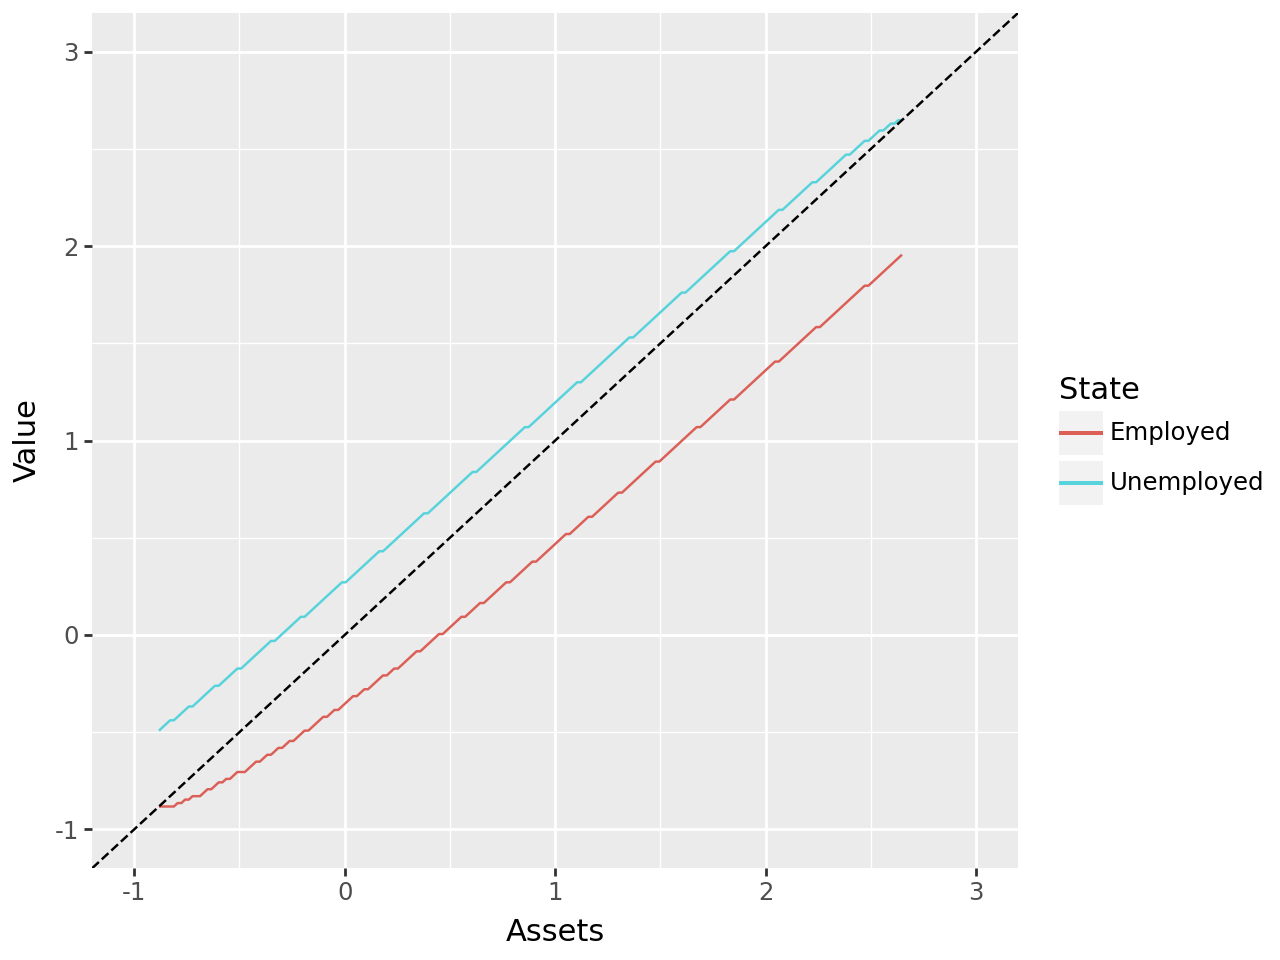

In [13]:
a_data = pl.DataFrame({
    'Assets': a_grid,
    'Employed': policy_a[:, 1],
    'Unemployed': policy_a[:, 0]
}).unpivot(
    index = 'Assets', on = ['Employed', 'Unemployed'],
    variable_name = 'State', value_name = 'Value'
)

(
    ggplot(a_data, aes('Assets', 'Value', color = 'State'))
    + gg.geom_line()
    + gg.geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
)

array([2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782609,
       2.64782609, 2.64782609, 2.64782609, 2.64782609, 2.64782

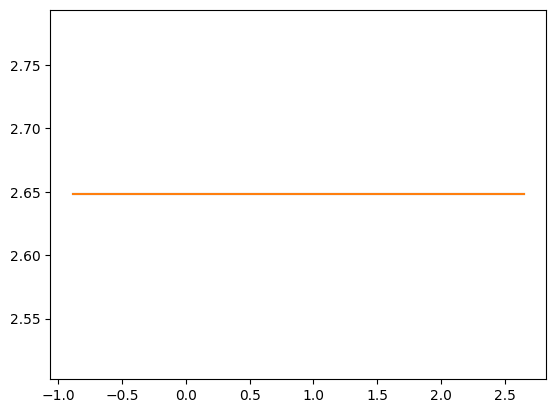

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(a_grid, policy_a[:, 0], label='Empregado')
plt.plot(a_grid, policy_a[:, 1], label='Desempregado')
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
beta = 0.96**(1/6)  # Fator de desconto
sigma = 1.5  # Aversão ao risco
r_ano = 0.034  # Taxa de juros anual
#q = 1 / (1 + r)  # Preço dos ativos
tol = 1e-6  # Tolerância para convergência
max_iter = 1000  # Número máximo de iterações
r = (1+r_ano)**(1/6)-1

# Estados de produtividade (empregado e desempregado)
z = np.array([1, 0.1])  # z[0] = empregado, z[1] = desempregado

# Matriz de probabilidades de transição
pr = np.array([[0.925, 0.075], [0.5, 0.5]])

# Resolvendo para a distribuição estacionária
eigvals, eigvecs = np.linalg.eig(pr.T)
stationary = eigvecs[:, np.isclose(eigvals, 1)].flatten().real
stationary = stationary / stationary.sum()

# Calculando a renda média
average_income = np.dot(stationary, z)

print(average_income)

# Grade de ativos
N = 200  # Número de pontos no grid
a_l = -average_income  # Restrição de endividamento (renda de um ano)
a_h = 3 * average_income  # Limite superior (3 vezes a renda média)
a_grid = np.linspace(a_l, a_h, N)  # Grade de ativos

# Inicializa as funções valor e as funções de política
V = np.zeros((N, 2))  # V(a, z) para cada nível de ativos e estado
policy_a = np.zeros((N, 2), dtype=int)  # Política ótima de ativos (índices de a_grid)
policy_c = np.zeros((N, 2))  # Política ótima de consumo

# Parâmetros
beta = 0.96**(1/6)  # Fator de desconto
sigma = 1.5  # Aversão ao risco
tol = 1e-6  # Tolerância para convergência
max_iter = 1000  # Número máximo de iterações
n = 2  # Número de estados possíveis

# Estados de produtividade (empregado e desempregado)
z = np.array([1, 0.1])  # z[0] = empregado, z[1] = desempregado

# Matriz de probabilidades de transição
pr = np.array([[0.925, 0.075], [0.5, 0.5]])

# Resolvendo para a distribuição estacionária
eigvals, eigvecs = np.linalg.eig(pr.T)
stationary = eigvecs[:, np.isclose(eigvals, 1)].flatten().real
stationary = stationary / stationary.sum()

# Calculando a renda média
average_income = np.dot(stationary, z)

# Grade de ativos
m = 200  # Número de pontos no grid
a_l = -average_income  # Restrição de endividamento (renda de um ano)
a_h = 3 * average_income  # Limite superior (3 vezes a renda média)
a_grid = np.linspace(a_l, a_h, m)  # Grade de ativos

0.882608695652174


In [2]:
V = np.zeros((m, n))  # Funções de valor iniciais para ambos os estados (empregado/desempregado)
policy_a = np.zeros((m, n))  # Armazena as políticas de ativos ótimas
# Precomputa as matrizes de consumo para ambos os estados
c1 = (1 + r) * a_grid[:, np.newaxis] + z[0] - a_grid  # Consumo no estado alto
c2 = (1 + r) * a_grid[:, np.newaxis] + z[1] - a_grid  # Consumo no estado baixo
# Garante consumo não negativo
c1 = np.maximum(c1, 1e-10)
c2 = np.maximum(c2, 1e-10)
# Função de utilidade para ambos os estados (vetorizada)
U1 = (c1 ** (1 - sigma) - 1) / (1 - sigma)
U2 = (c2 ** (1 - sigma) - 1) / (1 - sigma)


In [5]:
c1.shape

(200, 200)

In [3]:
for iteration in range(max_iter):
    EV = beta * np.dot(V, pr.T)  # Valor esperado para ambos os estados
    V1_new = U1 + EV[:, 0]  # Função de valor para empregado
    V2_new = U2 + EV[:, 1]  # Função de valor para desempregado
    new_V1 = np.max(V1_new, axis=1)
    new_V2 = np.max(V2_new, axis=1)
    opt_a1 = np.argmax(V1_new, axis=1)  # Índice do ativo que maximiza o valor para empregados
    opt_a2 = np.argmax(V2_new, axis=1)  # Índice do ativo que maximiza o valor para desempregados
    
    policy_a[:, 0] = a_grid[opt_a1]  # Armazena a política para empregados
    policy_a[:, 1] = a_grid[opt_a2]  # Armazena a política para desempregados
    # Verifica convergência
    if np.max(np.abs(new_V1 - V[:, 0])) < tol and np.max(np.abs(new_V2 - V[:, 1])) < tol:
        break
    
    V[:, 0] = new_V1
    V[:, 1] = new_V2

In [14]:
policy_a

array([[-0.49230937, -0.8826087 ],
       [-0.47456849, -0.8826087 ],
       [-0.45682762, -0.8826087 ],
       [-0.43908674, -0.8826087 ],
       [-0.43908674, -0.8826087 ],
       [-0.42134586, -0.86486782],
       [-0.40360498, -0.86486782],
       [-0.3858641 , -0.84712694],
       [-0.36812322, -0.84712694],
       [-0.36812322, -0.82938606],
       [-0.35038235, -0.82938606],
       [-0.33264147, -0.82938606],
       [-0.31490059, -0.81164518],
       [-0.29715971, -0.7939043 ],
       [-0.27941883, -0.7939043 ],
       [-0.26167795, -0.77616343],
       [-0.26167795, -0.75842255],
       [-0.24393708, -0.75842255],
       [-0.2261962 , -0.74068167],
       [-0.20845532, -0.74068167],
       [-0.19071444, -0.72294079],
       [-0.17297356, -0.70519991],
       [-0.17297356, -0.70519991],
       [-0.15523269, -0.70519991],
       [-0.13749181, -0.68745903],
       [-0.11975093, -0.66971816],
       [-0.10201005, -0.65197728],
       [-0.08426917, -0.65197728],
       [-0.06652829,